In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import timeit
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers

%load_ext tensorboard

print("Using TensorFlow version %s" % tf.__version__)
import tensorflow.experimental.numpy as tnp

ModuleNotFoundError: No module named 'tensorflow'

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


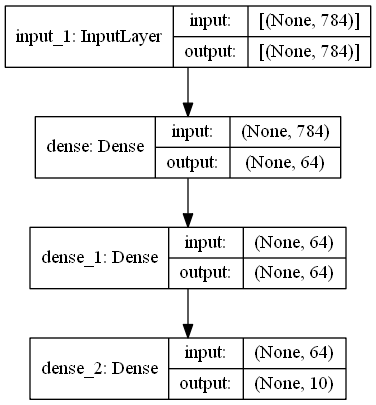

TensorShape([None, 784])

In [2]:
# Creation of model is different in Sequential and Functional API
# only shape of each sample. No batch size needed here
# eg: img_inputs = keras.Input(shape=(28, 28, 3))
inputs = keras.Input(shape=(784,))
# draw arrow from inputs to dense
dense = layers.Dense(64, activation="relu")
x = dense(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)
# create a model now
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

inputs.shape

In [3]:
# training, evaluation, prediction, saving is similar to sequential
# eg MNIST image dataset -> load, reshape, compile, fit with validation, prediction on test data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

Epoch 1/2
750/750 [==============================] - 3s 3ms/step - loss: 0.5930 - accuracy: 0.8340 - val_loss: 0.1856 - val_accuracy: 0.9459
Epoch 2/2
750/750 [==============================] - 1s 1ms/step - loss: 0.1738 - accuracy: 0.9464 - val_loss: 0.1451 - val_accuracy: 0.9600
313/313 - 0s - loss: 0.1404 - accuracy: 0.9578
Test loss: 0.14040710031986237
Test accuracy: 0.9577999711036682
INFO:tensorflow:Assets written to: path_to_my_model\assets


In [4]:
# Use same graph of layers to define multiple models
# eg autoencoder: 
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

In [5]:
# Models are like layers. Calling a model => adding the architectire and reusing its weights
# like auto encoder
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 1)            129         input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            129         input_5[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1)            129         input_5[0][0]                    
____________________________________________________________________________________________

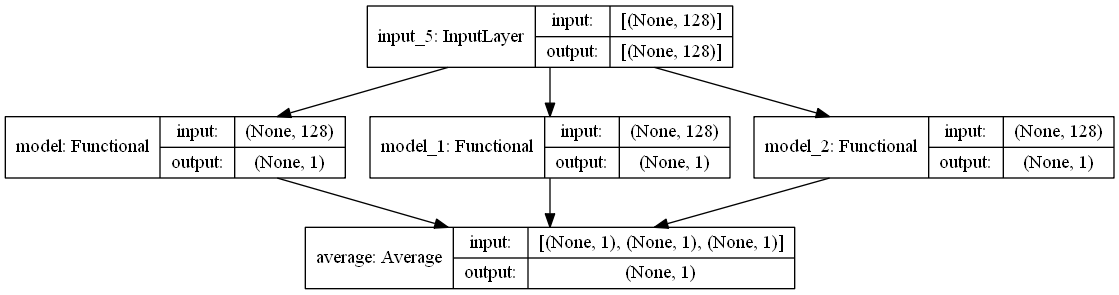

In [6]:
# Ensembling -> ensemble a set of models into a single model that averages their prediction
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
ensemble_model.summary()
keras.utils.plot_model(ensemble_model, show_shapes=True)


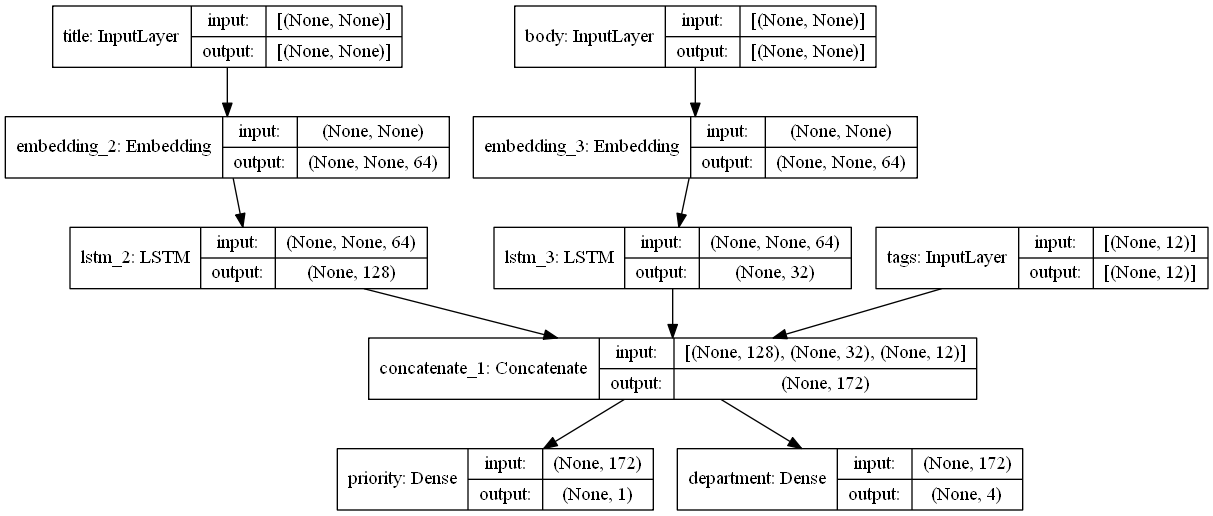

Epoch 1/2
40/40 [==============================] - 11s 54ms/step - loss: 1.2647 - priority_loss: 0.7095 - department_loss: 2.7760
Epoch 2/2
40/40 [==============================] - 2s 55ms/step - loss: 1.2571 - priority_loss: 0.6991 - department_loss: 2.7903


In [8]:
# Models with multiple input and output --> Only possible in Functional API
# title of ticket, body of ticket, tags by user 
# priority score, department to ahndle ticket

num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name="title")  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name="tags")  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[title_input, body_input, tags_input],outputs=[priority_pred, department_pred],)

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


#model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
#    loss=[
#        keras.losses.BinaryCrossentropy(from_logits=True),
#        keras.losses.CategoricalCrossentropy(from_logits=True),
#    ],
#    loss_weights=[1.0, 0.2],
#)

#Or like
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)


Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_23[0][0]                  
_________________________________________________________________________________________

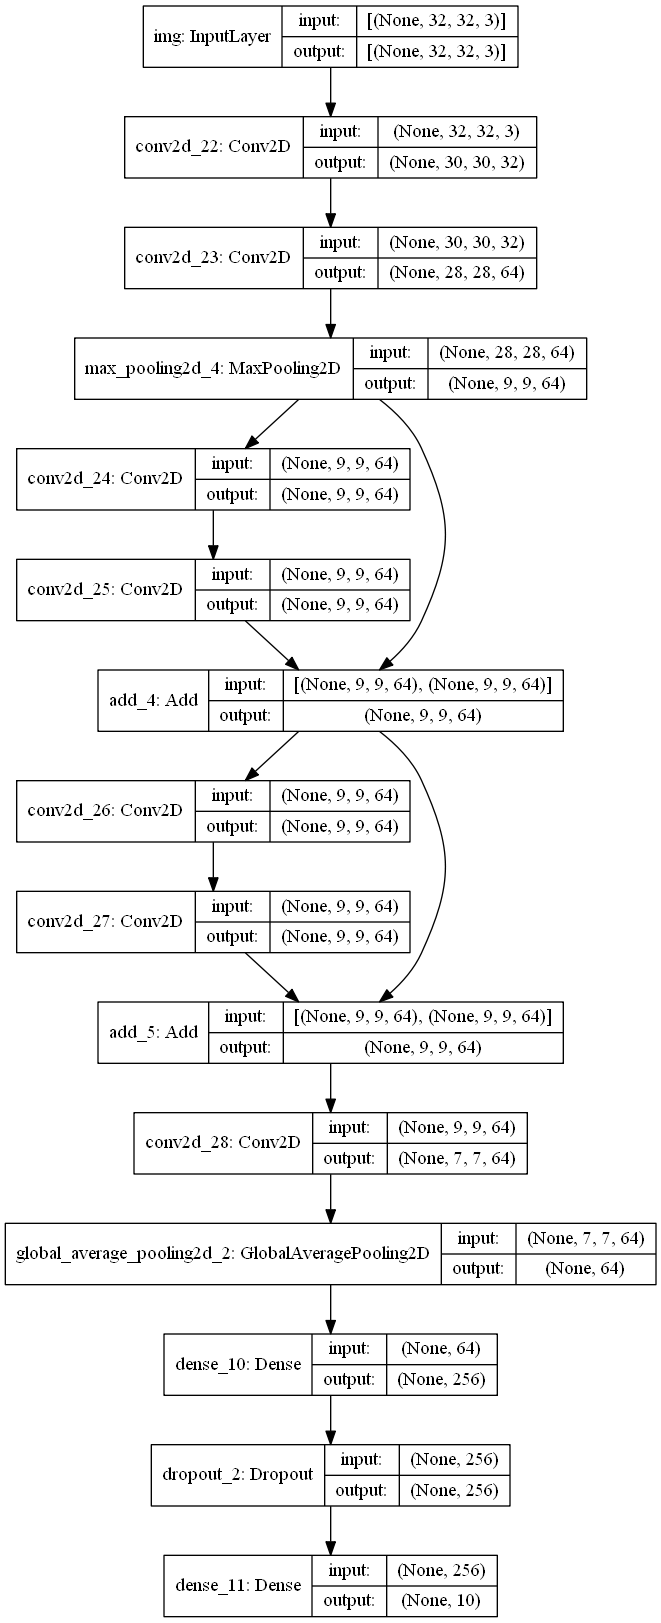

13/13 [==============================] - 7s 290ms/step - loss: 2.3435 - acc: 0.1190 - val_loss: 2.2776 - val_acc: 0.1150


In [14]:
# non-linear connectivity topology (Models wgere layers are not connected sequentially)
# eg ResNet model below
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

In [ ]:
# share layer
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)


In [15]:
vgg19 = tf.keras.applications.VGG19()


574717952/574710816 [==============================] - 430s 1us/step


In [17]:
features_list = [layer.output for layer in vgg19.layers]
features_list

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_6')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv4')>,

In [18]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)
img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

In [19]:
# Extend the API using custom layers

SyntaxError: invalid syntax (<ipython-input-19-31a33097391c>, line 1)